<a href="https://colab.research.google.com/github/Shibarashii/nail-disease-classifier/blob/main/models/resnet50_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ResNet50 Base**
## Summary
- Model: `ResNet50`
    - Total params: `23,528,522`
- Data Transforms:
    - `Resize(224, 224)`
    - `Normalize()`
- Criterion: `CrossEntropyLoss`
- Optimizer: `AdamW`
    - Learning Rate: `1e-4`
- Scheduler: `StepLR`
Documentation: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html

## **0. Installing and Importing Libraries**

In [1]:
!pip install torchmetrics torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
import torch
import torchvision
import torchmetrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from pathlib import Path
from utils import helpers

## **1. Data Preparation**

### 1.1. Data access and directory setup


In [3]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')

DATA_DIR = Path("/content/drive/MyDrive/Nail disease detection/data/")
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR = DATA_DIR / "valid"
TEST_DIR = DATA_DIR / "test"

Mounted at /content/drive


### 1.2. Transforming data to tensors and normalization
- Transforms for transforming images to tensors
- Resizing to 224x224 and normalizing it to be consistent with the pretrained images

In [4]:
from torchvision import transforms as T

transforms = T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

### 1.3. Loading the data

In [5]:
from torchvision.datasets import ImageFolder

train_data = ImageFolder(root=TRAIN_DIR, transform=transforms)
val_data = ImageFolder(root=VAL_DIR, transform=transforms)
test_data = ImageFolder(root=TEST_DIR, transform=transforms)

CLASS_NAMES = train_data.classes
NUM_CLASSES = len(CLASS_NAMES)

In [6]:
from torch.utils.data import DataLoader
from utils.constants import RANDOM_SEED

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

val_dataloader = DataLoader(dataset=val_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

print(f"Train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print(f"Valid dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")

img, label = next(iter(train_dataloader))

print(f"\nSample batch image shape: \n\t{img.shape}")
print(f"Sample batch label shape: \n\t{label.shape}")

Train dataloader: 199 batches of 32
Test dataloader: 10 batches of 32
Valid dataloader: 19 batches of 32

Sample batch image shape: 
	torch.Size([32, 3, 224, 224])
Sample batch label shape: 
	torch.Size([32])


### 1.4. Dataset summary

In [ ]:
from utils.helpers import get_class_distribution

train_count = len(train_data)
val_count = len(val_data)
test_count = len(test_data)
total_count = train_count + val_count + test_count

print(f"Total number of images: {total_count}")
print(f"Training Set: {train_count} ({train_count / total_count * 100:.0f}%)")
print(f"Validation Set: {val_count} ({val_count / total_count * 100:.0f}%)")
print(f"Test Set: {test_count} ({test_count / total_count * 100:.0f}%)")

get_class_distribution(train_data, "Training Set")
get_class_distribution(val_data, "Validation Set")
get_class_distribution(test_data, "Test Set")

Total number of images: 7258
Training Set: 6360 (88%)
Validation Set: 591 (8%)
Test Set: 307 (4%)

Class distribution in Training Set:
Acral Lentiginous Melanoma: 753
Beaus Line               : 456
Blue Finger              : 612
Clubbing                 : 783
Healthy Nail             : 642
Koilonychia              : 537
Muehrckes Lines          : 336
Onychogryphosis          : 690
Pitting                  : 657
Terry-s Nail             : 894

Class distribution in Validation Set:
Acral Lentiginous Melanoma: 70
Beaus Line               : 44
Blue Finger              : 59
Clubbing                 : 74
Healthy Nail             : 54
Koilonychia              : 52
Muehrckes Lines          : 31
Onychogryphosis          : 65
Pitting                  : 61
Terry-s Nail             : 81

Class distribution in Test Set:
Acral Lentiginous Melanoma: 36
Beaus Line               : 22
Blue Finger              : 29
Clubbing                 : 38
Healthy Nail             : 30
Koilonychia              : 28


## **2. Model Building**

### 2.1. Setting up device-agnostic code

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### 2.2 Loading model with pre-trained weights and adjusting output layer to match `NUM_CLASSES`

In [8]:
import torchvision.models as models
from torchmetrics import Accuracy
from torch import nn

WEIGHTS = models.ResNet50_Weights.DEFAULT

model = models.resnet50(weights=WEIGHTS)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, NUM_CLASSES)  # 10 classes

for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer4 and fc layers
for name, param in model.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        param.requires_grad = True

model = model.to(device)

print(f"Model parameters are on: {next(model.parameters()).device}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 120MB/s]


Model parameters are on: cuda:0


### 2.3. Weighted loss for class imbalance

In [9]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Based on your class distribution
train_counts = [753, 456, 612, 783, 643, 537, 336, 690, 657, 894]
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.arange(len(train_counts)),
                                     y=np.repeat(np.arange(len(train_counts)), train_counts))

weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

### 2.4 Setting up loss function, optimizer, scheduler, and accuracy function

In [10]:
from torch.optim.lr_scheduler import StepLR
from torchmetrics import Accuracy
from torch import nn

LR = 1e-4
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=LR)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # decay LR every 5 epochs
accuracy_fn = Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(device)

### 2.5 Model Summary

In [13]:
from torchinfo import summary

summary(model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 10]                  --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

## **3. Model Training**

In [12]:
from utils.helpers import train_model

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

EPOCHS = 5

results = train_model(epochs=EPOCHS,
                      model=model,
                      train_dataloader=train_dataloader,
                      valid_dataloader=val_dataloader,
                      criterion=criterion,
                      optimizer=optimizer,
                      accuracy_fn=accuracy_fn,
                      device=device,
                      scheduler=scheduler)


  0%|          | 0/5 [00:00<?, ?it/s]

Looked at 0 / 6360 samples
Looked at 320 / 6360 samples
Looked at 640 / 6360 samples
Looked at 960 / 6360 samples
Looked at 1280 / 6360 samples
Looked at 1600 / 6360 samples
Looked at 1920 / 6360 samples
Looked at 2240 / 6360 samples
Looked at 2560 / 6360 samples
Looked at 2880 / 6360 samples
Looked at 3200 / 6360 samples
Looked at 3520 / 6360 samples
Looked at 3840 / 6360 samples
Looked at 4160 / 6360 samples
Looked at 4480 / 6360 samples
Looked at 4800 / 6360 samples
Looked at 5120 / 6360 samples
Looked at 5440 / 6360 samples
Looked at 5760 / 6360 samples
Looked at 6080 / 6360 samples
Epoch: 0 | Train loss: 1.4081, Train accuracy : 0.5512 | Valid loss: 0.9319, Valid accuracy: 0.7008
Looked at 0 / 6360 samples
Looked at 320 / 6360 samples
Looked at 640 / 6360 samples
Looked at 960 / 6360 samples
Looked at 1280 / 6360 samples
Looked at 1600 / 6360 samples
Looked at 1920 / 6360 samples
Looked at 2240 / 6360 samples
Looked at 2560 / 6360 samples
Looked at 2880 / 6360 samples
Looked at 32

## **4. Model Evaluation**

### 4.1. Saving and loading results into dataframe

In [21]:
import pandas as pd
from utils.helpers import save_results, load_results

OUTPUTS_PATH = Path("outputs")
MODEL_NAME = "resnet50"

RESULTS_DIR = "results"

FULL_DIR_NAME = OUTPUTS_PATH / MODEL_NAME / RESULTS_DIR
FULL_DIR_NAME.parent.mkdir(parents=True, exist_ok=True)

results_file = save_results(dir_name=FULL_DIR_NAME,
                            file_name=MODEL_NAME,
                            results=results)

df = load_results(dir_name=FULL_DIR_NAME,
                  file_name=MODEL_NAME,
                  run="latest")

df

,train_loss,train_acc,valid_loss,valid_acc
0,1.408099,0.551193,0.931895,0.700768
1,0.485582,0.841866,0.761315,0.750987
2,0.168246,0.948440,0.783319,0.763925
3,0.081667,0.977387,0.760484,0.775877
4,0.050110,0.986024,0.814573,0.777303


### 4.2. Plotting results

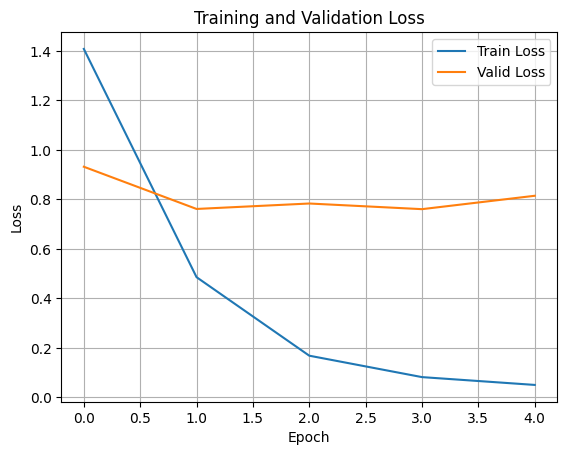

In [15]:
plt.plot(df["train_loss"], label="Train Loss")
plt.plot(df["valid_loss"], label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

### 4.3. Making predictions and comparing to ground truth

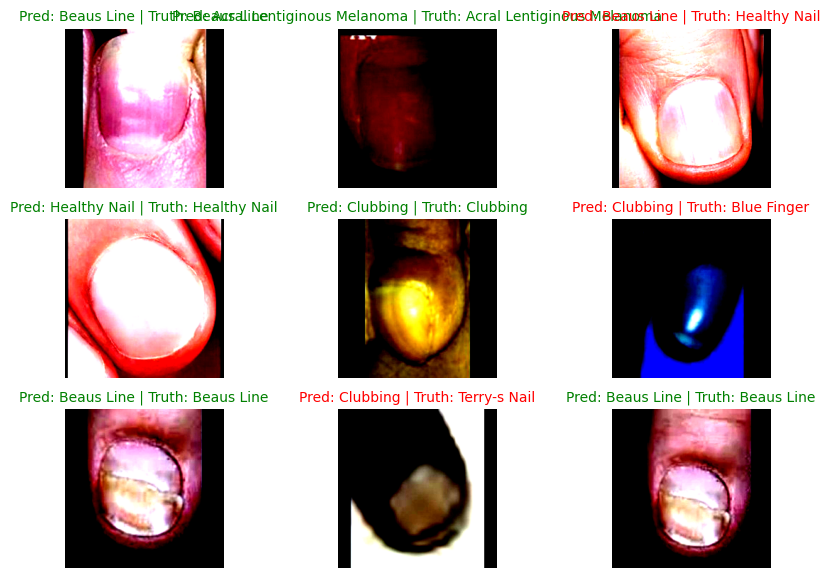

In [16]:
from utils.helpers import predict_compare

predict_compare(test_data=test_data,
                model=model,
                device=device,
                class_names=CLASS_NAMES,
                random_seed=RANDOM_SEED)

### 4.4. Evaluating test set and plotting confusion matrix

In [17]:
from utils.helpers import make_predictions

y_preds, y_true = make_predictions(model=model,
                                   test_dataloader=test_dataloader,
                                   test_data=test_data,
                                   device=device)

Making predictions:   0%|          | 0/10 [00:00<?, ?it/s]

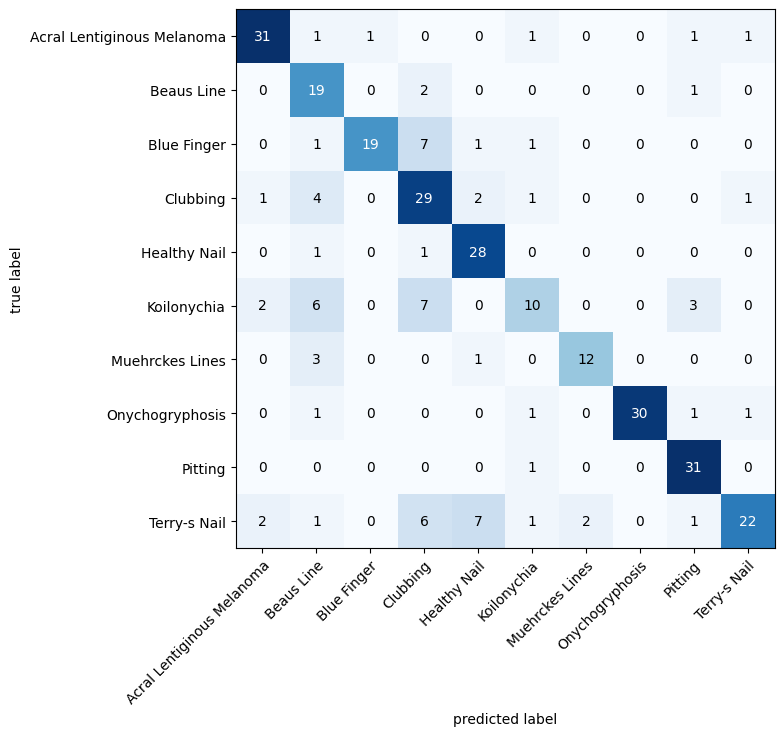

In [18]:
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

conf_mat = ConfusionMatrix(task="multiclass", num_classes=len(CLASS_NAMES))
conf_mat_tensor = conf_mat(y_preds, y_true)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat_tensor.numpy(), class_names=CLASS_NAMES, figsize=(10,7))

### 4.5. Classification Report

In [19]:
from sklearn.metrics import classification_report
report = classification_report(y_preds, y_true, target_names=CLASS_NAMES)
print(report)

                            precision    recall  f1-score   support

Acral Lentiginous Melanoma       0.86      0.86      0.86        36
                Beaus Line       0.86      0.51      0.64        37
               Blue Finger       0.66      0.95      0.78        20
                  Clubbing       0.76      0.56      0.64        52
              Healthy Nail       0.93      0.72      0.81        39
               Koilonychia       0.36      0.62      0.45        16
           Muehrckes Lines       0.75      0.86      0.80        14
           Onychogryphosis       0.88      1.00      0.94        30
                   Pitting       0.97      0.82      0.89        38
              Terry-s Nail       0.52      0.88      0.66        25

                  accuracy                           0.75       307
                 macro avg       0.76      0.78      0.75       307
              weighted avg       0.80      0.75      0.76       307



## **5. Saving Model Weights**

In [22]:
epoch = 5
RESULTS_DIR = "weights"
FILE_NAME = f"{MODEL_NAME}_epoch{epoch}.pth"

MODEL_SAVE_PATH = OUTPUTS_PATH / MODEL_NAME / RESULTS_DIR / FILE_NAME
MODEL_SAVE_PATH.parent.mkdir(parents=True, exist_ok=True)

print(f"Saving to {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving to outputs/resnet50/weights/resnet50_epoch5.pth


## **6. Transfer Learning**

### 6.1. Preparing pre-trained weights

In [ ]:
from pathlib import Path

OUTPUTS_PATH = Path("outputs")
MODEL_NAME = "resnet50"
WEIGHTS_DIR = "weights"
epoch = None
FILE_NAME = f"{MODEL_NAME}_epoch{epoch}.pth"

WEIGHTS_PATH = OUTPUTS_PATH / MODEL_NAME / WEIGHTS_DIR / FILE_NAME

state_dict = torch.load(f=WEIGHTS_PATH, map_location=device)

### 6.2. Replicating model architecture and loading pre-trained weights

In [ ]:
model = models.vgg16()
model.classifier[6] = nn.Linear(in_features=4096, out_features=len(CLASS_NAMES))
model = model.to(device)

# Loading weights
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

### 6.3. Re-training the model

In [ ]:
from utils.helpers import train_model

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

EPOCHS = 5

results = train_model(epochs=EPOCHS,
                      model=model,
                      train_dataloader=train_dataloader,
                      valid_dataloader=val_dataloader,
                      criterion=criterion,
                      optimizer=optimizer,
                      accuracy_fn=accuracy_fn,
                      device=device,
                      scheduler=scheduler)

### 6.4. Saving and loading results into dataframe

In [ ]:
import pandas as pd
from utils.helpers import save_results, load_results

RESULTS_DIR = "results"

FULL_DIR_NAME = OUTPUTS_PATH / MODEL_NAME / RESULTS_DIR
FULL_DIR_NAME.parent.mkdir(parents=True, exist_ok=True)

FILE_NAME = "efficientnetv2s"
results_file = save_results(dir_name=FULL_DIR_NAME,
                            file_name=FILE_NAME,
                            results=results)

df = load_results(dir_name=FULL_DIR_NAME,
                  file_name=FILE_NAME,
                  run="latest")

df

### 6.5 Saving model weights

In [ ]:
epoch = None  # CHANGE THIS DEPENDING ON THE EPOCH
RESULTS_DIR = "weights"
FILE_NAME = f"{MODEL_NAME}_epoch{epoch}.pth"

MODEL_SAVE_PATH = OUTPUTS_PATH / MODEL_NAME / RESULTS_DIR / FILE_NAME
MODEL_SAVE_PATH.parent.mkdir(parents=True, exist_ok=True)

print(f"Saving to {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)